In [1]:
import pandas as pd
import numpy as np
import pickle
from collections import Counter
import math
import nltk
import requests
import html
import datetime
from datetime import timedelta, date
import string
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score

import statsmodels as sm

%matplotlib inline

In [2]:
data = pd.read_csv("../../dados/resultado.csv", header = None) 

* Data da mensagem
* Usuário que postou a mensagem
* Texto da mensagem
* Pontuação para  classe=paródia
* Pontuação para  classe=opinião
* Pontuação para  classe=campanha
* Pontuação para  classe=experiência pessoal
* Pontuação para  classe=informação
* Resultado (qual a classe foi escolhida pela maior pontuação)
* Informação (JSON) sobre a localização

In [3]:
data.columns = ["date", "user", "message", "0", "1", "2", "3", "4", "class", "location"]

In [4]:
data['date'] = pd.to_datetime(data['date'])

In [5]:
data.dtypes

date        datetime64[ns]
user                object
message             object
0                  float64
1                  float64
2                  float64
3                  float64
4                  float64
class                int64
location            object
dtype: object

In [6]:
data = data[data['date'] < '2011-09-30 23:59:59']

# save pickle of filtered data

# load pickle

In [314]:
with open('../../inputs/resultado.pkl', 'rb') as f:
    data = pickle.load(f)

In [315]:
data = data[data['date'] < '2011-09-30 23:59:59']

In [316]:
data['date'] = data['date'].dt.strftime("%Y-%m-%d")

In [317]:
data['date'] = pd.to_datetime(data['date'])

In [318]:
data.tail()

,date,user,message,0,1,2,3,4,class,location
738140,2011-09-12,claricereis91,"@berntfinal Dengue num dá dor na garganta, vc ...",0.147137,0.066065,0.069753,0.544475,0.172570,0,"{u'd': 1460387911967, u'v': 1}"
738141,2011-09-12,guinisinmypants,@DearDany Todos os sintomas de dengue.. Até do...,0.130242,0.059683,0.119528,0.488431,0.202117,0,"{u'd': 1460387911968, u'v': 1}"
738142,2011-09-12,eu_plfl,a @pqjade_ tem problemas e dengue no #cerebro,0.295350,0.144311,0.110989,0.201095,0.248256,1,"{u'city': u'Sao Jose dos Pinhais', u'country':..."
738143,2011-09-12,Pathy_Aleixo,@ronaldoarreios Tô com dengue.... Meu corpo da...,0.084619,0.036423,0.048278,0.739830,0.090849,0,"{u'd': 1460387912416, u'v': 1}"
738144,2011-09-12,_rachelmarques,Minha ta mais parada do que foco de mosquito d...,0.500673,0.088380,0.053413,0.200705,0.156830,1,"{u'city': u'Rio de Janeiro', u'country': u'Bra..."


In [319]:
data.shape

(603588, 10)

# stopwords

In [320]:
stopwords = nltk.corpus.stopwords.words('portuguese')
stopwords = list(set(stopwords))

In [321]:
try: stopwords.remove('não')
except: pass

In [322]:
#algumas pontuaçoes podem ser irrelevantes
some_punctuation = '-.,'

In [323]:
def remove_stopwords(text):
    new_text = ""
    for word in text.lower().split():
        if word not in stopwords and len(word)>1:
            word = word.strip(some_punctuation)
            new_text = new_text + ' ' + word
    return new_text

new column: text without stopwords

In [324]:
data['message_nostopwords'] = data['message'].apply(remove_stopwords)

# build epidemiologic weeks
* Week one of every year is the first week with 4 days or more.
* Timestamp of the study comprises: 21/11/2010-30/09/2011

In [325]:
def daterange(date1, date2):
    for n in range(int ((date2 - date1).days)+1):
        yield date1 + timedelta(n)

start_dt = date(2010, 1, 1)
end_dt = date(2011, 10, 30)
dates = []
for dt in daterange(start_dt, end_dt):
    dates.append(dt.strftime("%Y-%m-%d"))

In [326]:
dates_2010 = dates[:365]
dates_2011 = dates[365:]

In [327]:
ep_week_lst = []
count = 0
epidemic_week = 1
ep_week_lst.extend([201000]*2)
for d in dates_2010[2:]:
    if count == 7:
        epidemic_week += 1
        count = 0
    count += 1
    str_week = str(epidemic_week)
    if len(str_week) == 1: str_week = '0'+str_week
    year_week = '2010'+str_week
    ep_week_lst.append(year_week)
    
count = 0
epidemic_week = 1
ep_week_lst.append(201100)
for d in dates_2011[1:]:
    if count == 7:
        epidemic_week += 1
        count = 0
    count += 1
    str_week = str(epidemic_week)
    if len(str_week) == 1: str_week = '0'+str_week
    year_week = '2011'+str_week
    ep_week_lst.append(year_week)

In [328]:
datetime.datetime.strptime("21/12/2008 20:04:44", "%d/%m/%Y %H:%M:%S").strftime("%Y-%m-%d")

'2008-12-21'

In [329]:
data.dtypes

date                   datetime64[ns]
user                           object
message                        object
0                             float64
1                             float64
2                             float64
3                             float64
4                             float64
class                           int64
location                       object
message_nostopwords            object
dtype: object

In [330]:
def date_to_epweek(row):
    #print(type(row))
    #print(row)
    row = row.strftime("%Y-%m-%d")
    date_index = dates.index(row)
    year_week = ep_week_lst[date_index]
    return year_week
data['se'] = data['date'].apply(date_to_epweek) #se = epidemiologic week

In [331]:
data.head()

,date,user,message,0,1,2,3,4,class,location,message_nostopwords,se
0,2010-11-19,PauloAfBahia,A dengue mata mas com simples gestos de preven...,0.138010,0.101521,0.254248,0.085880,0.420341,3,"{u'd': 1443198862750, u'v': 1}",dengue mata simples gestos prevenção podemos ...,201046
1,2010-11-19,PortalOuroNegro,Mutirão contra a Dengue começou nesta sexta em...,0.105452,0.056434,0.248333,0.188912,0.400869,3,"{u'city': u'Linhares', u'country': u'Brasil', ...",mutirão contra dengue começou nesta sexta lin...,201046
2,2010-11-19,Kustelaas,@depChicoAlencar amannhã alem do dia da consiê...,0.054194,0.084122,0.213530,0.146927,0.501226,3,"{u'country': u'Brasil', u'state': u'MT', u'typ...",@depchicoalencar amannhã alem dia consiência ...,201046
3,2010-11-19,Raul_Jungmann,Pernambuco tem risco de sofrer epidemia de den...,0.080289,0.106928,0.054929,0.141276,0.616577,3,"{u'city': u'Recife', u'country': u'Brasil', u'...",pernambuco risco sofrer epidemia dengue http:...,201046
4,2010-11-19,laana_mello,Rpz...acho q a Caueira tah com surto de dengue...,0.112013,0.143425,0.094947,0.429626,0.219990,0,"{u'country': u'Brasil', u'state': u'MT', u'typ...",rpz...acho caueira tah surto dengue soh pode....,201046


# Infodengue
The research comprises 12 cities:
* Belém, Belo Horizonte, Brasília,Fortaleza, Manaus, Natal, Rio Branco, Rio de Janeiro, São Paulo, Londrina, Niterói, Ribeirão Preto.
* Source of geocodes: https://ww2.ibge.gov.br/home/geociencias/geografia/redes_fluxos/gestao_do_territorio_2014/base.shtm
* File of the geocodes: Base_de_dados_dos_municipios.xls

### geocodes

In [33]:
geocodes_BR = pd.read_excel (r'..\inputs\Base_de_dados_dos_municipios.xls')
geocodes_BR = geocodes_BR[['UF', 'Codmundv', 'NomeMunic']]

### infodengue - Rio de Janeiro

In [3]:
municipality= 'Rio de Janeiro'.upper()
geocode_row = geocodes_BR.loc[geocodes_BR['NomeMunic'] == municipality]
geocode = list(geocode_row.iloc[:,1])[0]
url = 'https://info.dengue.mat.br/api/alertcity/?geocode=3304557&disease=dengue&format=csv&ew_start=47&ey_start=2010&ew_end=39&ey_end=2011'
r = requests.get(url)
if r:
    print('Success!')
else:
    print('An error has occurred.')

Success!


In [4]:
r.headers

{'Server': 'nginx/1.4.6 (Ubuntu)', 'Date': 'Wed, 08 May 2019 21:25:08 GMT', 'Content-Type': 'text/plain', 'Content-Length': '11546', 'Connection': 'keep-alive', 'X-Frame-Options': 'SAMEORIGIN', 'Vary': 'Accept-Language, Cookie, Accept-Encoding', 'Content-Language': 'pt-br', 'Content-Encoding': 'gzip'}

In [5]:
r = r.text.split('\n')

In [6]:
count = 0
for row in r:
    split_row = row.split(',')
    r[count] = split_row
    count += 1
headers = r.pop(0)

In [7]:
infodengue = pd.DataFrame(r, columns=headers)
infodengue = infodengue.iloc[:,2:6]
infodengue.head()

,se,data,tweets,casos
0,201112,2011-03-20,,530
1,201135,2011-08-28,,12
2,201104,2011-01-23,,56
3,201123,2011-06-05,,29
4,201101,2011-01-02,,10


In [8]:
infodengue.shape

(451, 4)

In [9]:
infodengue['casos'] = infodengue['casos'].fillna(0).astype(int)

In [10]:
infodengue = infodengue.groupby(['se']).sum()

In [11]:
infodengue.head()

,casos
se,
201047,74
201048,93
201049,149
201050,195
201051,155


### check epidemiologic week consistency

In [356]:
df_week_pairs = list(zip(list(infodengue['se']), list(infodengue['data'])))
const_week_pairs = list(zip(ep_week_lst, dates))

In [357]:
consistent = True
for i in df_week_pairs: 
    if i not in const_week_pairs and i != (None, None):
        consistent = False
        print('Please, check the epidemic weeks construction again')
        break
if consistent: print('Weeks were correctly built')

Weeks were correctly built


### group tweet data by week, and filter irrelevant columns

In [332]:
data = data[['message_nostopwords', 'se']]

In [333]:
data = data.groupby(['se'])['message_nostopwords'].apply(lambda x: ' '.join(x))

In [334]:
data = pd.DataFrame(data)

In [335]:
data_bak = data.copy()

In [337]:
data_bak.head()

,message_nostopwords
se,
201002,aqui casa repelente estocado deus livre pegar...
201006,rt @souintelijente: urgente alerta informar m...
201010,lol rt @dropsbh: @aakkari praga perto dengue ...
201015,@gehalls xiii dengue! @felipeazevedo10 to de...
201019,"campanha combate dengue ""tropa"" trocou branco..."


In [311]:
data = data_bak

# TF-IDF

* https://www.kdnuggets.com/2018/08/wtf-tf-idf.html
* using elastic search: https://stackoverflow.com/questions/42220764/elasticsearch-getting-the-tf-idf-of-every-term-in-a-given-document

limitar por frequencia relativa

tf/total de palavras

In [338]:
tfidf = TfidfVectorizer(
    analyzer='word')  

In [339]:
tfidf.fit(data['message_nostopwords'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [340]:
idf_counter = Counter()
for text in data['message_nostopwords']:
    words = set(text.lower().split())
    idf_counter.update(words)
    
idf = {
  word: math.log(len(data)/df, 2)
  for word, df in idf_counter.items()
}

In [341]:
counter = Counter()
for text in data['message_nostopwords']:
    words = text.lower().split()
    counter.update(words)

In [597]:
tf_top = sorted(counter, key=counter.get)[-500:]

In [419]:
idf_top = sorted(idf, key=idf.get)[:50]

In [345]:
# nao funciona, pq idf foi zerado
def tfidf(text, term):
    text = text.lower().split()
    
    tfidf = 0
    tf = 0
    for word in text:
        if word == term:
            tf += 1
    tfidf = (1 + math.log(tf, 2)) * idf[term]
    #tfidf = idf[term]
    return tfidf

In [526]:
#usando freq absoluta
def abs_tf(text, term):
    text = text.lower().split()
    
    tf = 0
    for word in text:
        if word == term:
            tf += 1
    return tf

In [527]:
for term in tf_top:
    data[term] = 0
    data[term] = data['message_nostopwords'].apply(lambda text: abs_tf(text, term))

pickle files

In [12]:
with open('../../resultado_TFs.pkl', 'rb') as f:
    data = pickle.load(f)

In [13]:
len(data.columns)

501

# Lasso regression
Using Lasso to choose the most relevant terms

In [14]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoLarsIC

In [15]:
infodengue = infodengue.rename(index=str, columns={"casos": "y"})

In [16]:
data = pd.merge(data, infodengue, on='se', how='inner')

In [17]:
x_variables = data.columns[1:-1]
x_variables

Index(['nao', 'dengue:', 'vida', 'bem', 'dengue!', 'rio', 'parado', 'foco',
       'caso', 'gente',
       ...
       'todos', 'estado', 'cidade', 'virar', 'combater', 'médico', 'epidemia',
       'sabe', 'agua', 'tipo'],
      dtype='object', length=500)

In [69]:
y = data.iloc[:, -1:]

In [19]:
X = data.iloc[:, 1:-1]

In [20]:
X.head()

,nao,dengue:,vida,bem,dengue!,rio,parado,foco,caso,gente,...,todos,estado,cidade,virar,combater,médico,epidemia,sabe,agua,tipo
se,,,,,,,,,,,,,,,,,,,,,
201047,130,211,41,514,426,1707,216,71,37,100,...,241,90,757,5,86,50,101,270,542,37
201048,33,48,12,80,73,86,74,35,17,28,...,30,7,17,2,31,14,18,38,77,12
201050,166,153,35,212,218,113,189,93,73,110,...,138,35,114,10,79,59,100,49,134,28
201051,78,113,300,102,135,81,101,84,39,1638,...,74,17,41,7,93,31,31,27,91,18
201101,441,522,232,542,887,681,469,456,389,640,...,291,332,530,89,277,281,191,283,264,136


In [21]:
y.head()

,y
se,
201047,74
201048,93
201050,195
201051,155
201101,212


In [22]:
lasso = Lasso(alpha=10, normalize=True)

### define variables

In [23]:
def retrieve_lasso_alpha(X_, alpha_space):
   # for X in Xs:
    lasso_scores = []
    lasso_scores_std = []
    for alpha in alpha_space:
    
        # Specify the alpha value to use: lasso.alpha
        lasso.alpha = alpha
        
        # Perform 5-fold CV: lasso_cv_scores
        lasso_cv_scores = cross_val_score(lasso, X_, y, cv=5)
        
        # Append the mean of lasso_cv_scores to lasso_scores
        lasso_scores.append(np.mean(lasso_cv_scores))
        
        # Append the std of lasso_cv_scores to lasso_scores_std
        lasso_scores_std.append(np.std(lasso_cv_scores))
    print(lasso_scores)
    best_alpha = alpha_space[lasso_scores.index(max(lasso_scores))]
    print(best_alpha)

    return best_alpha

In [24]:
def plot_lasso_coef(X, y, alpha):
    lasso = Lasso(alpha=alpha, normalize=True)
    
    # Fit the regressor to the data
    lasso.fit(X, y)
    
    # Compute and print the coefficients
    lasso_coef = lasso.coef_ 
    #print('lasso coefficients: \r\n', lasso_coef)
    
    # Plot the coefficients
    plt.figure(figsize=(16,5))
    plt.plot(range(len(lasso_coef)), lasso_coef)
    plt.xticks(rotation=60)
    plt.xlabel("Variable")
    plt.ylabel("Lasso coefficient")
    plt.margins(0.02)
    plt.show()
    return lasso_coef

In [25]:
def print_vars(coefs, threshold):
    for coef in coefs:
        if abs(coef) > threshold: print(x_variables[list(coefs).index(coef)])

In [26]:
alpha_space = np.logspace(-4, 0, 10)
alpha_space = np.append(alpha_space,[5,10, 25, 50])

In [27]:
Xs = [data.iloc[:, 1:51], data.iloc[:, 1:-1]]

### working with 500 features

#### lassoIC (AIC)

In [291]:
lassoic = LassoLarsIC(criterion='aic')

In [292]:
def plot_lassoIC_coef(X, y):
    lassoic = LassoLarsIC(criterion='aic')
    
    # Fit the regressor to the data
    lassoic.fit(X, y)
    
    # Compute and print the coefficients
    lasso_coef = lasso.coef_ 
    #print('lasso coefficients: \r\n', lasso_coef)
    
    # Plot the coefficients
    plt.figure(figsize=(16,5))
    plt.plot(range(len(lasso_coef)), lasso_coef)
    plt.xticks(rotation=60)
    plt.xlabel("Variable")
    plt.ylabel("Lasso coefficient")
    plt.margins(0.02)
    plt.show()
    return lasso_coef

In [293]:
lassoic = LassoLarsIC()
lassoic.fit(X, y)

D:\Users\Marcelo\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LassoLarsIC(copy_X=True, criterion='aic', eps=2.220446049250313e-16,
      fit_intercept=True, max_iter=500, normalize=True, positive=False,
      precompute='auto', verbose=False)

In [294]:
lassoic.score(X,y)

0.28753851724909407

In [282]:
print('alpha using LassoLarsIC is:', lassoic.alpha_)

alpha using LassoLarsIC is: 176.25895643390677


D:\Users\Marcelo\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


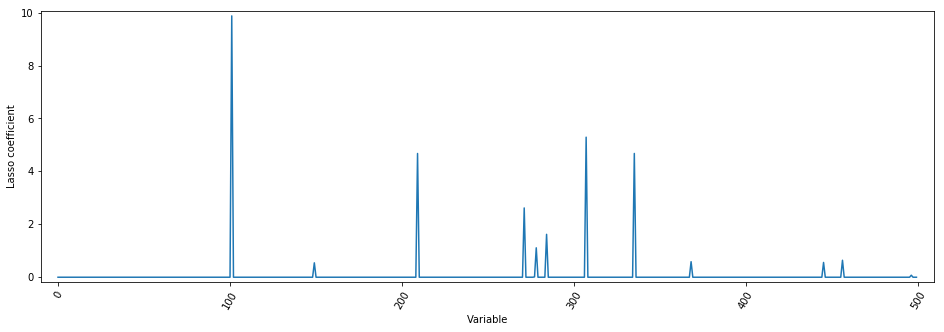

In [283]:
lasso_coef_IC = plot_lassoIC_coef(X,y)

#### lassoIC (BIC)

In [82]:
lassoic = LassoLarsIC(criterion='bic')

In [83]:
def plot_lassoIC_coef(X, y):
    lassoic = LassoLarsIC(criterion='bic')
    
    # Fit the regressor to the data
    lassoic.fit(X, y)
    
    # Compute and print the coefficients
    lasso_coef = lasso.coef_ 
    #print('lasso coefficients: \r\n', lasso_coef)
    
    # Plot the coefficients
    plt.figure(figsize=(16,5))
    plt.plot(range(len(lasso_coef)), lasso_coef)
    plt.xticks(rotation=60)
    plt.xlabel("Variable")
    plt.ylabel("Lasso coefficient")
    plt.margins(0.02)
    plt.show()
    return lasso_coef

In [84]:
lassoic = LassoLarsIC()
lassoic.fit(X, y)

D:\Users\Marcelo\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LassoLarsIC(copy_X=True, criterion='aic', eps=2.220446049250313e-16,
      fit_intercept=True, max_iter=500, normalize=True, positive=False,
      precompute='auto', verbose=False)

In [85]:
lassoic.score(X,y)

0.28753851724909407

In [95]:
print('alpha using LassoLarsIC is:', lassoic.alpha_)

alpha using LassoLarsIC is: 176.25895643390677


D:\Users\Marcelo\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


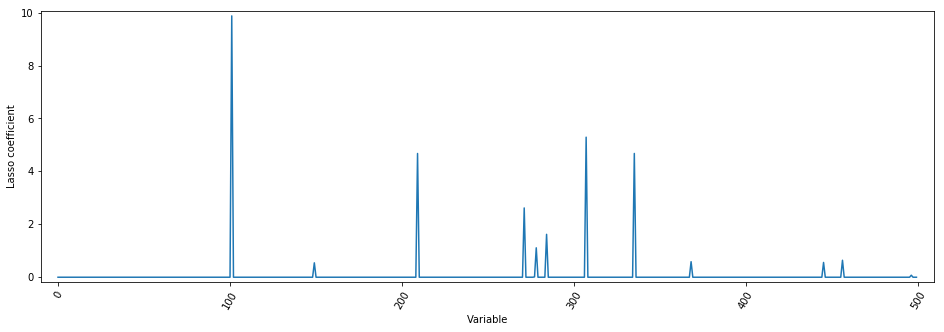

In [87]:
lasso_coef_IC = plot_lassoIC_coef(X,y)

In [88]:
print_vars(lasso_coef_IC, 0.8)

:d
mesmo
sp
paulo
sempre
natal
exame


#### Plot information criteria

In [70]:
X = data.iloc[:, 1:-1]
X = remove_vars(X, lasso_coef, 1)

In [100]:
-np.log10(0.1)

1.0

In [104]:
lassoic.criterion_

array([ 43.        ,  43.9457133 ,  38.97565077,  40.20089184,
        40.86614714,  41.128114  ,  40.45555578,  41.77027357,
        43.451452  ,  44.20991975,  47.7231728 ,  50.08577015,
        52.6490178 ,  55.09134005,  57.15053853,  58.57599551,
        58.54335374,  56.43962768,  54.37757196,  54.195117  ,
        55.74569362,  57.33378899,  58.17110142,  57.95293634,
        57.76979655,  59.77615456,  61.77445429,  64.04468577,
        66.43020866,  68.99238213,  71.66385434,  73.84129471,
        73.87452559,  73.61913087,  72.05790494,  69.21952021,
        71.08403268,  71.07355995,  70.86466892,  72.64488271,
        74.59562074,  76.56952446,  78.49892663,  78.49805449,
        78.50280811,  80.60003676,  82.62613342,  82.79963876,
        80.83118686,  80.86157086,  82.88883329,  84.91542897,
        87.23892975,  89.24622097,  91.31703619,  93.56369559,
        95.60956036,  93.85130475,  95.99913546,  98.16761335,
       100.18987435, 100.33712525, 100.37214694, 100.56

Automatically created module for IPython interactive environment


C:\Users\marcelo.old-note\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\marcelo.old-note\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\marcelo.old-note\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log10


Computing regularization path using the coordinate descent lasso...


C:\Users\marcelo.old-note\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Computing regularization path using the Lars lasso...


C:\Users\marcelo.old-note\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\marcelo.old-note\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:96: RuntimeWarning: divide by zero encountered in log10


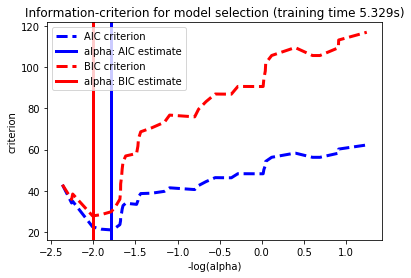

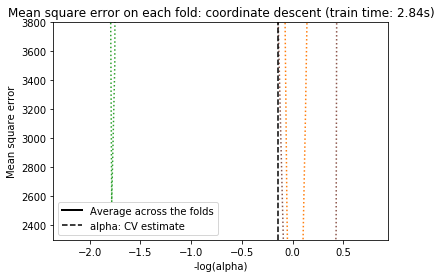

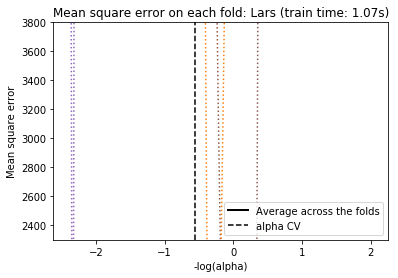

In [104]:
print(__doc__)

# Author: Olivier Grisel, Gael Varoquaux, Alexandre Gramfort
# License: BSD 3 clause

import time

import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC
from sklearn import datasets

#diabetes = datasets.load_diabetes()
#X = diabetes.data
#y = diabetes.target

rng = np.random.RandomState(42)
X = np.c_[X, rng.randn(X.shape[0], 14)]  # add some bad features

# normalize data as done by Lars to allow for comparison
X /= np.sqrt(np.sum(X ** 2, axis=0))

# #############################################################################
# LassoLarsIC: least angle regression with BIC/AIC criterion

model_bic = LassoLarsIC(criterion='bic')
t1 = time.time()
model_bic.fit(X, y)
t_bic = time.time() - t1
alpha_bic_ = model_bic.alpha_

model_aic = LassoLarsIC(criterion='aic')
model_aic.fit(X, y)
alpha_aic_ = model_aic.alpha_


def plot_ic_criterion(model, name, color):
    alpha_ = model.alpha_
    alphas_ = model.alphas_
    #print('alphas_', alphas_) #print test
    criterion_ = model.criterion_
    plt.plot(-np.log10(alphas_), criterion_, '--', color=color,
             linewidth=3, label='%s criterion' % name)
    plt.axvline(-np.log10(alpha_), color=color, linewidth=3,
                label='alpha: %s estimate' % name)
    plt.xlabel('-log(alpha)')
    plt.ylabel('criterion')

plt.figure()
plot_ic_criterion(model_aic, 'AIC', 'b')
plot_ic_criterion(model_bic, 'BIC', 'r')
plt.legend()
plt.title('Information-criterion for model selection (training time %.3fs)'
          % t_bic)

# #############################################################################
# LassoCV: coordinate descent

# Compute paths
print("Computing regularization path using the coordinate descent lasso...")
t1 = time.time()
model = LassoCV(cv=20).fit(X, y)
t_lasso_cv = time.time() - t1

# Display results
m_log_alphas = -np.log10(model.alphas_)

plt.figure()
ymin, ymax = 2300, 3800
plt.plot(m_log_alphas, model.mse_path_, ':')
plt.plot(m_log_alphas, model.mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(-np.log10(model.alpha_), linestyle='--', color='k',
            label='alpha: CV estimate')

plt.legend()

plt.xlabel('-log(alpha)')
plt.ylabel('Mean square error')
plt.title('Mean square error on each fold: coordinate descent '
          '(train time: %.2fs)' % t_lasso_cv)
plt.axis('tight')
plt.ylim(ymin, ymax)

# #############################################################################
# LassoLarsCV: least angle regression

# Compute paths
print("Computing regularization path using the Lars lasso...")
t1 = time.time()
model = LassoLarsCV(cv=20).fit(X, y)
t_lasso_lars_cv = time.time() - t1

# Display results
m_log_alphas = -np.log10(model.cv_alphas_)

plt.figure()
plt.plot(m_log_alphas, model.mse_path_, ':')
plt.plot(m_log_alphas, model.mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(-np.log10(model.alpha_), linestyle='--', color='k',
            label='alpha CV')
plt.legend()

plt.xlabel('-log(alpha)')
plt.ylabel('Mean square error')
plt.title('Mean square error on each fold: Lars (train time: %.2fs)'
          % t_lasso_lars_cv)
plt.axis('tight')
plt.ylim(ymin, ymax)

plt.show()

#### normal lasso

In [74]:
X = data.iloc[:, 1:-1]
best_alpha = retrieve_lasso_alpha(X, alpha_space)

D:\Users\Marcelo\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
D:\Users\Marcelo\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
D:\Users\Marcelo\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
D:\Users\Marcelo\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want t

[-6089.0885007517445, -6089.512534752319, -6090.633018281007, -6093.658295278253, -6111.5112937502945, -5333.022950634172, -2674.265535929502, -1348.4546018469923, -891.631522936492, -135.84750340468497, -118.0374005196309, -116.40804544995208, -129.3236508533925, -134.94040260429756]
10.0


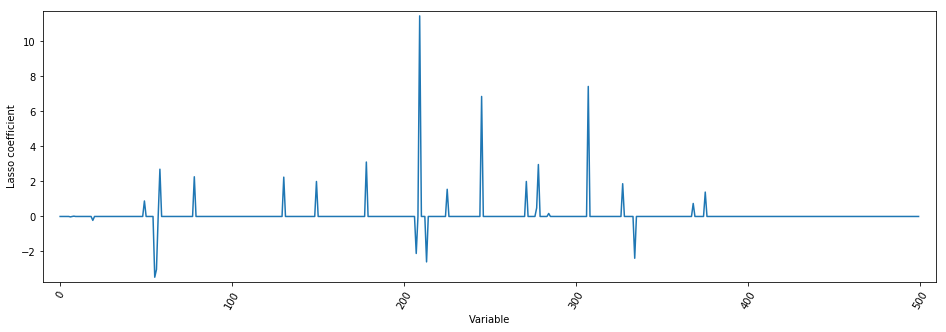

In [75]:
lasso_coef = plot_lasso_coef(X,y, best_alpha)

In [76]:
print_vars(lasso_coef, 0.8)

vc
pneu
feia
mi
show
notificações
mato
antes
usar
mesmo
três
morrer
tempo
sp
paulo
natal
saber
@minsaude:
cidades


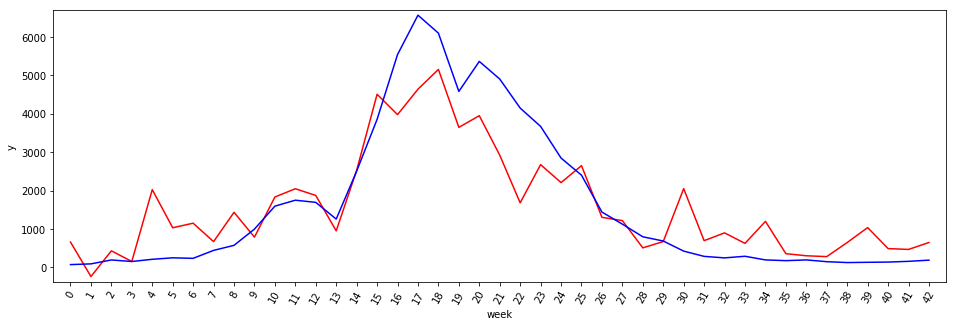

In [77]:
lasso.fit(X, y)
y_pred = lasso.predict(X)

# Plot the coefficients
plt.figure(figsize=(16,5))
plt.plot(range(len(y)), y_pred, 'r')
plt.plot(range(len(y)), y, 'b')

plt.xticks(range(len(X)), list(range(50)), rotation=60)
plt.xlabel("week")
plt.ylabel("y")
plt.margins(0.02)
plt.show()

In [78]:
lasso.score(X,y)

0.782628786722346

### working with 50 features

In [669]:
X_50 = data.iloc[:, 1:51]
best_alpha_50 = retrieve_lasso_alpha(X_50, alpha_space)

D:\Users\Marcelo\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
D:\Users\Marcelo\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
D:\Users\Marcelo\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
D:\Users\Marcelo\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want t

[-3113.6674023922174, -3112.4755027237993, -3109.237744363657, -3021.7079609410694, -3027.2548110857015, -3155.9691466194263, -4709.632036265898, -10627.618461855514, -19249.816688312283, -14346.439735793694, -7620.634423313006, -2896.362132902329, -624.0827864254367, -312.228075617057]
50.0


D:\Users\Marcelo\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
D:\Users\Marcelo\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
D:\Users\Marcelo\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
D:\Users\Marcelo\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want t

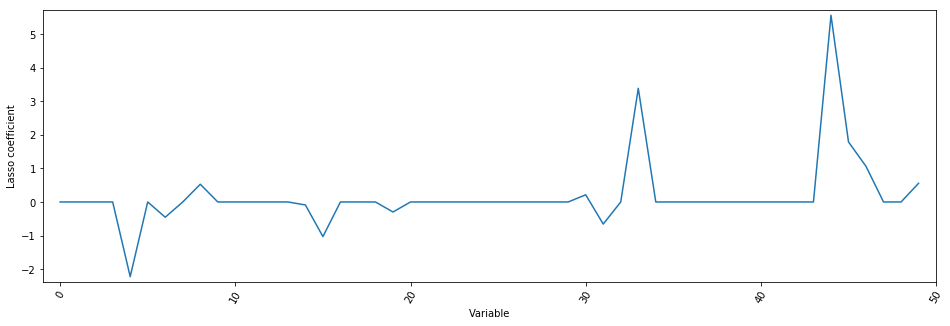

In [673]:
lasso_coef_50 = plot_lasso_coef(X_50,y, best_alpha)

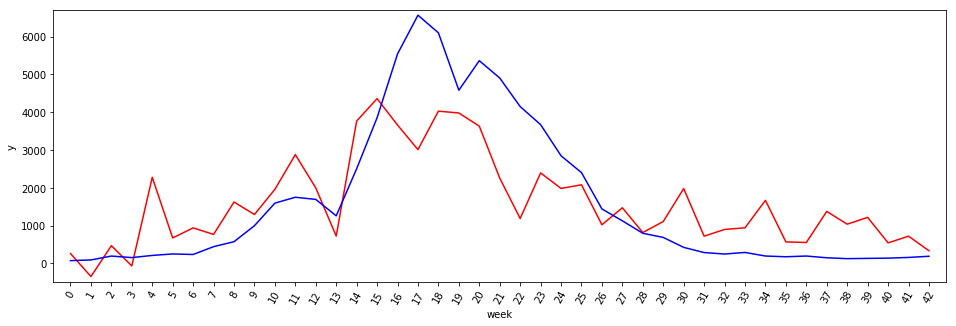

In [675]:
lasso.fit(X_50, y)
y_pred = lasso.predict(X_50)

# Plot the coefficients
plt.figure(figsize=(16,5))
plt.plot(range(len(y)), y_pred, 'r')
plt.plot(range(len(y)), y, 'b')

plt.xticks(range(len(X_50)), list(range(50)), rotation=60)
plt.xlabel("week")
plt.ylabel("y")
plt.margins(0.02)
plt.show()

In [245]:
lasso.get_params()

{'alpha': 50.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': 1000,
 'normalize': True,
 'positive': False,
 'precompute': False,
 'random_state': None,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

In [689]:
print_vars(lasso_coef_50, 1)

dengue!
#dengue
casa
acho
pode
hoje


### feature selection of Xs of 500 features

In [48]:
def remove_vars(data_features, coefs, threshold):
    var_indexes = []
    for coef in coefs:
        if abs(coef) > threshold: 
            var_index = list(coefs).index(coef)
            var_indexes.append(var_index)
    data_features = data_features[data_features.columns[var_indexes]]
    return data_features

In [54]:
X = remove_vars(X, lasso_coef, 1)

# Linear regression - Baseline

In [55]:
from sklearn.linear_model import LinearRegression

In [61]:
X_full = data.iloc[:, 1:-1]

In [56]:
linear = LinearRegression(normalize = True)

Ao usar linear regression com features selecionadas pelo lasso, por acaso degenerei o modelo?? confirmar com flavio

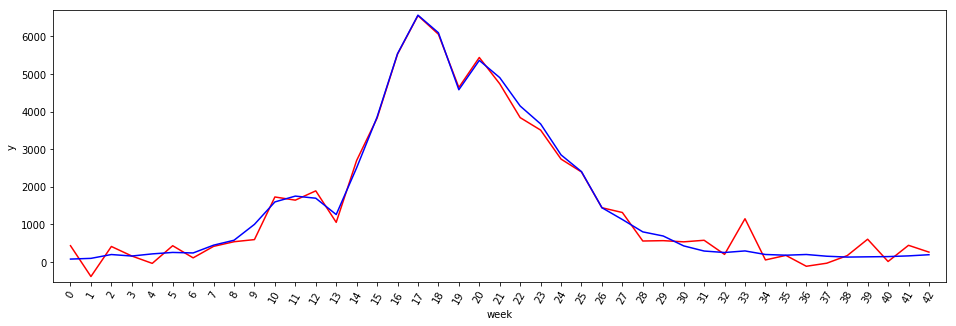

In [58]:
linear.fit(X, y)
y_pred = linear.predict(X)

# Plot the coefficients
plt.figure(figsize=(16,5))
plt.plot(range(len(y)), y_pred, 'r')
plt.plot(range(len(y)), y, 'b')

plt.xticks(range(len(X)), list(range(50)), rotation=60)
plt.xlabel("week")
plt.ylabel("y")
plt.margins(0.02)
plt.show()

In [59]:
linear.score(X,y)

0.9845939441444382

If I use the full set of features, it overfits!!!!

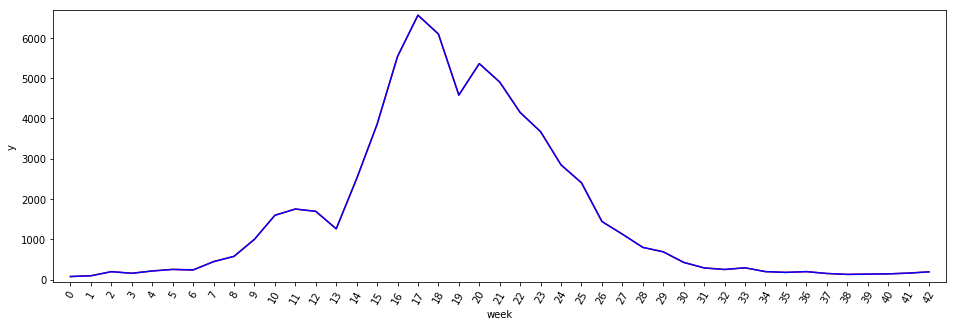

In [62]:
linear.fit(X_full, y)
y_pred = linear.predict(X_full)

# Plot the coefficients
plt.figure(figsize=(16,5))
plt.plot(range(len(y)), y_pred, 'r')
plt.plot(range(len(y)), y, 'b')

plt.xticks(range(len(X)), list(range(50)), rotation=60)
plt.xlabel("week")
plt.ylabel("y")
plt.margins(0.02)
plt.show()

In [64]:
linear.score(X_full,y)

1.0

# analisar correlacao cruzada, com lag
* using heatmaps: https://www.kaggle.com/dedecu/cross-correlation-time-lag-with-pandas
* convolution: https://www.youtube.com/watch?v=hBTGuOe9txE
* the lag between signals is given by the argmax of the cross-correlation: https://en.wikipedia.org/wiki/Cross-correlation#Time_delay_analysis
* A value of -1 means that in1 is 1 lag behind. A value of 2 means that in1 is 2 lag in advanced. Negative values mean that in1 precedes/predicts in2.

In [80]:
from scipy import signal

X_array = X.T.values
y_array = [list(y.y) for x in range(len(X_array))]
corrs = signal.correlate(X_array, y_array, mode='same')

In [103]:
count = 0
for corr in corrs:
    center = int(len(corr)/2)
    lag = np.argmax(corr) - center
    print('feature: ', X.columns[count], '; lag: ', lag)
    count += 1

feature:  pneu ; lag:  -1
feature:  feia ; lag:  -2
feature:  mi ; lag:  -2
feature:  show ; lag:  -2
feature:  notificações ; lag:  -2
feature:  mato ; lag:  -1
feature:  antes ; lag:  -1
feature:  usar ; lag:  -1
feature:  mesmo ; lag:  -1
feature:  três ; lag:  -1
feature:  morrer ; lag:  -1
feature:  tempo ; lag:  -1
feature:  sp ; lag:  -1
feature:  paulo ; lag:  -1
feature:  natal ; lag:  -1
feature:  saber ; lag:  -1
feature:  @minsaude: ; lag:  -1
feature:  cidades ; lag:  -1


# ML model

In [46]:
from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

### Create train and test sets

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [43]:
len(X_test)

13

In [44]:
len(X_train)

30

### random forest

In [161]:
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier()
steps = [('RandomF', clf_rf)]
pipeline = Pipeline(steps)

# Fit the pipeline to the train set
pipeline.fit(X_train, y_train)

# Predict the labels of the test set
y_pred = pipeline.predict(X_test)

# Loss function
error_random_forest = mean_squared_error(y_test,y_pred)

D:\Users\Marcelo\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Users\Marcelo\Anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


In [167]:
from sklearn.neighbors import KNeighborsClassifier

clf_knn = KNeighborsClassifier(n_neighbors = 3)
steps = [('KNN', clf_knn)]
pipeline = Pipeline(steps)

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

error_knn =  mean_squared_error(y_test,y_pred)

D:\Users\Marcelo\Anaconda3\lib\site-packages\sklearn\pipeline.py:267: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


In [168]:
from sklearn.svm import SVC

clf_svc = SVC()
steps = [('SVC', clf_svc)]
pipeline = Pipeline(steps)

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

error_svc =  mean_squared_error(y_test,y_pred)

D:\Users\Marcelo\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Users\Marcelo\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [170]:
models = pd.DataFrame({
    'Model': ['randomforest', 'knn', 'svc'],
    'Error': [error_random_forest, error_knn, error_svc]})
models.sort_values(by='Error')

,Model,Error
1,knn,6.620117e+05
0,randomforest,1.848979e+06
2,svc,2.177867e+07


### cross validation

In [181]:
len(y)

43

In [194]:
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier()

random_forest_cv = cross_val_score(clf_rf, X,y, cv=2)

D:\Users\Marcelo\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=2.
  % (min_groups, self.n_splits)), Warning)
D:\Users\Marcelo\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Users\Marcelo\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
D:\Users\Marcelo\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 

In [187]:
random_forest_cv

array([0.02380952, 0.        ])

# draft

# notas
scipy signal correlate, para automatizar correlacao com lags em vez de plotar na mao. seria mais interessante se eu pegar 24-36 meses em vez de 1 ano (periodo de comparacao do paper)

GLM - generalised linear model

usar linear regression como baseline